In [1]:
# %matplotlib notebook

In [1]:
import torchvision
from torchvision.io.image import read_image
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch
from torchvision import transforms

import cv2 as cv
from PIL import Image
# from PIL import Resampling
import numpy as np

import glob

import time
import copy

from torchvision.models import vgg19_bn, VGG19_BN_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Step 1: Initialize model with the best available weights
sdd_weights = SSD300_VGG16_Weights.DEFAULT
# model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model = ssd300_vgg16(weights=sdd_weights)
# model.to('cuda')
model = model.eval()

In [126]:
def find_objects (filepath, num_imgs):
    img = read_image(filepath)
    img = img[:3,:,:]
    preprocess = sdd_weights.transforms()
    batch = [preprocess(img).to(device)]
    prediction = model(batch)[0]
    labels = [sdd_weights.meta["categories"][i] for i in prediction["labels"]]
    im = to_pil_image(img)
    outImgs = []
    for i in range(num_imgs):
        coords = prediction["boxes"][i+1].tolist()
        im1 = im.crop(coords)
        outImgs.append(im1)
    return outImgs

In [3]:
def save_cropped_objects (filepath, num_imgs, id):
    img = read_image(filepath)
    img = img[:3,:,:]
    preprocess = sdd_weights.transforms()
    batch = [preprocess(img)]
    prediction = model(batch)[0]
    labels = [sdd_weights.meta["categories"][i] for i in prediction["labels"]]
    im = to_pil_image(img)
    for i in range(num_imgs):
        coords = prediction["boxes"][i+1].tolist()
        # print(coords)
        im1 = im.crop(coords)
        im1.save("cropped_imgs/" + str(id) + "_" + str(i) + ".jpg")

In [ ]:
save_cropped_objects("dataset/elephant.jpg", 5, 1)

In [ ]:
filepath = 'dataset/raw/train/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

filepath = 'dataset/raw/test/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

filepath = 'dataset/raw/valid/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

In [17]:
filepath = 'alan_imgs/'
for i, filename in enumerate(glob.glob(filepath + '*.*')):
	save_cropped_objects(filename, 5, i)

# VGG Model

In [4]:
vggweights = VGG19_BN_Weights.DEFAULT
vggmodel = vgg19_bn(weights=vggweights)
vggmodel = vggmodel.eval()
vggmodel.to(device)
print()

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, numpydata, numpylabels, transform=None, target_transform=None):
        self.imgs = numpydata
        self.img_labels = numpylabels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = self.imgs[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def padImage(img):
    imgshape = np.array(img.shape[:-1])
    
    padding = abs(imgshape[1]-imgshape[0])
    
    if imgshape[1] > imgshape[0]:
        pad1 = np.zeros((padding//2 + padding%2, imgshape[1],3), dtype=int)
        pad2 = np.zeros((padding//2, imgshape[1],3), dtype=int)
        
        img = np.vstack((pad1,img,pad2))
    if imgshape[0] > imgshape[1]:
        pad1 = np.zeros((imgshape[0], padding//2 + padding%2, 3), dtype=int)
        pad2 = np.zeros((imgshape[0], padding//2,3), dtype=int)
        
        img = np.hstack((pad1, img, pad2))

    return img

def pilPad (im):
    desired_size = 224
    old_size = im.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

#     im = im.resize(new_size, Image.ANTIALIAS)
#     im = im.resize(new_size, Image.Resampling.LANCZOS)
    im = im.resize(new_size, Image.BILINEAR)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_im

def fixImage_filename(filename):
    img = padImage(np.array(cv.imread(filename))/255)
    img = cv.resize(img, (256,256), interpolation = cv.INTER_LINEAR)
    img = np.moveaxis(img, -1, 0)
    img = img.reshape(1,3,256,256)
    
    return img

def fixImage_img(img):
    return pilPad(img)

In [6]:
# pilPad(Image.open('sorted_imgs/train/box/6_1.jpg'))

In [7]:
# yes_x = np.empty((1,3,256,256))
# no_x = np.empty((1,3,256,256))

# for filename in glob.glob('sorted_imgs/box/*.*'):
#     img = fixImage_filename(filename)
#     no_x = np.concatenate((no_x, img))

# for filename in glob.glob('sorted_imgs/no_box/*.*'):
#     img = fixImage_filename(filename)
#     yes_x = np.concatenate((yes_x, img))

## Data Augmentation

In [18]:
# def show_dataset(dataset, n=6):
#   img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
#                    for i in range(len(dataset))))
#   plt.imshow(img)
#   plt.axis('off')

In [6]:
class custom_fix_image(object):
    def __init__(self):
        pass
    
    def __call__(self, img):
        img = fixImage_img(img)
        return img

    def __repr__(self):
        return "Padding and resizing image"
    
class convertToCuda(object):
    def __init__(self, device):
        self.device = device
    
    def __call__(self, t):
        t_device = t.to(device=self.device)
        return t_device

    def __repr__(self):
        return "Changes tensor to device"

In [7]:
transforms_pytorch = torchvision.transforms.Compose([
    custom_fix_image(),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = torchvision.transforms.Compose([
    custom_fix_image(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# datasets = {
#     'box': torchvision.datasets.ImageFolder('./sorted_imgs/box/', transform=transforms_pytorch),
#     'no_box': torchvision.datasets.ImageFolder('./sorted_imgs/no_box/', transform=transforms_pytorch)
# }
# for mode in ('box', 'no_box'):
#     show_dataset(datasets[mode])
train_folder_dataset = torchvision.datasets.ImageFolder('./sorted_imgs/train/', transform=transforms_pytorch)
valid_folder_dataset = torchvision.datasets.ImageFolder('./sorted_imgs/validation/', transform=val_transforms)

# print(train_folder_dataset)
# for batch,c in train_folder_dataset:
#     break
#     d.save("sorted_imgs/aug_imgs/" + str(id) + "_" + str(i) + ".jpg")
# show_dataset(dataset)

In [132]:
# batch_size = 16

# yes_x = yes_x[1:]
# no_x = no_x[1:]

# p_split = int(len(yes_x)*0.8)
# np_split = int(len(no_x)*0.8)

# train_x = np.vstack((no_x[:np_split], yes_x[:p_split]))
# valid_x = np.vstack((no_x[np_split:], yes_x[p_split:]))

# train_y = [0] * np_split + [1] * p_split
# valid_y = [0] * (len(no_x) - np_split) + [1] * (len(yes_x) - p_split)

# train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
# valid_x = torch.tensor(valid_x, dtype=torch.float32, device=device)

# train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
# valid_y = torch.tensor(valid_y, dtype=torch.float32, device=device)

# data = CustomImageDataset(train_x, train_y)
# valid_data = CustomImageDataset(valid_x, valid_y)

# trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# valloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

# loaders = {
#     "train":trainloader,
#     "val":valloader
# }

In [8]:
batch_size = 12

trainloader = torch.utils.data.DataLoader(train_folder_dataset, batch_size=batch_size, shuffle=True) 
valloader = torch.utils.data.DataLoader(valid_folder_dataset, batch_size=batch_size, shuffle=False)

loaders = {
    "train":trainloader,
    "val":valloader
}

In [134]:
# for batch_img,batch_label in trainloader:
#     break
# batch_img.shape,batch_label.shape

In [9]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = "./cropped_imgs"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)


# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

#     mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1)
#     std = torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1)
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs -= mean
#                 inputs /= std
                
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
#                 print(inputs.shape)
                
                
                #print(inputs.type())
                #print(labels.type())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
#             input("Stop")
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# from noggin import create_plot

# plotter, fig, ax = create_plot(metrics=["loss", "accuracy"], last_n_batches=int(5e3))

In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(vggmodel.parameters())
optimizer = optim.AdamW(vggmodel.parameters())

# train_model(
#     model,
#     dataloaders,
#     criterion,
#     optimizer,
#     num_epochs=25,
#     is_inception=False,
# )

model, val_acc_history = train_model(vggmodel, loaders, criterion, optimizer)

Epoch 0/24
----------


C:\Users\evan_\AppData\Local\Temp\ipykernel_38712\228252884.py:48: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  im = im.resize(new_size, Image.BILINEAR)


train Loss: 4.2649 Acc: 0.5091
val Loss: 2.3457 Acc: 0.7308
Epoch 1/24
----------
train Loss: 0.8986 Acc: 0.6667
val Loss: 9.5993 Acc: 0.6154
Epoch 2/24
----------
train Loss: 0.9008 Acc: 0.6000
val Loss: 0.7463 Acc: 0.6154
Epoch 3/24
----------
train Loss: 0.7905 Acc: 0.5758
val Loss: 3.7774 Acc: 0.6154
Epoch 4/24
----------
train Loss: 0.6878 Acc: 0.6667
val Loss: 0.5601 Acc: 0.6923
Epoch 5/24
----------
train Loss: 0.6195 Acc: 0.6788
val Loss: 0.4145 Acc: 0.8077
Epoch 6/24
----------
train Loss: 0.5779 Acc: 0.7636
val Loss: 0.7129 Acc: 0.6154
Epoch 7/24
----------
train Loss: 0.7048 Acc: 0.7333
val Loss: 0.8312 Acc: 0.4615
Epoch 8/24
----------
train Loss: 0.6653 Acc: 0.6848
val Loss: 0.6372 Acc: 0.8077
Epoch 9/24
----------
train Loss: 0.5215 Acc: 0.8061
val Loss: 0.6818 Acc: 0.6923
Epoch 10/24
----------
train Loss: 0.5438 Acc: 0.7758
val Loss: 0.1582 Acc: 0.9615
Epoch 11/24
----------
train Loss: 0.4849 Acc: 0.8545
val Loss: 0.8036 Acc: 0.8077
Epoch 12/24
----------
train Loss: 0

In [11]:
torch.save(model, "vggmodel_aug.pb")

# Demo

## SSD Object Finding

In [192]:
demo_filepath = "demo_imgs/2.jpg"
objs = find_objects(demo_filepath, 5)

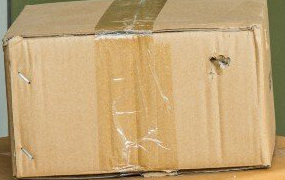

In [193]:
objs[0]

## VGG Binary Classification

In [194]:
demo_vgg_model = torch.load("vggmodel_aug.pb", map_location=device)
demo_vgg_model.eval()
print()

In [195]:
demo_transforms = torchvision.transforms.Compose([
    custom_fix_image(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

start_t = torch.FloatTensor(1, 3, 224, 224)

for img in objs:
    transformed_img = demo_transforms(img)[None, :, :, :]
    start_t = torch.cat((start_t, transformed_img))
    
demo_batch = start_t[1:]
print(demo_batch.shape)
demo_batch = demo_batch.to(device)
with torch.no_grad():
    outputs = demo_vgg_model(demo_batch)

torch.Size([5, 3, 224, 224])


C:\Users\evan_\AppData\Local\Temp\ipykernel_38712\228252884.py:48: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  im = im.resize(new_size, Image.BILINEAR)


In [196]:
scores = outputs[:,:2]
m = nn.Softmax(dim=1)
scores = m(scores)
print(scores)
scores[:,0] -= 0.95
print(scores)
answers = torch.argmax(scores, axis=1)
print(answers)
if (0 in answers):
    print("There is a package")
else:
    print("No package")

tensor([[3.2421e-01, 6.7579e-01],
        [1.8733e-01, 8.1267e-01],
        [1.9832e-01, 8.0168e-01],
        [1.9126e-01, 8.0874e-01],
        [1.0000e+00, 6.5378e-15]], device='cuda:0')
tensor([[-6.2579e-01,  6.7579e-01],
        [-7.6267e-01,  8.1267e-01],
        [-7.5168e-01,  8.0168e-01],
        [-7.5874e-01,  8.0874e-01],
        [ 5.0000e-02,  6.5378e-15]], device='cuda:0')
tensor([1, 1, 1, 1, 0], device='cuda:0')
There is a package
